In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [5]:
def load_data():
    df = pd.read_excel('DataSet.xlsx', sheet_name='Sheet1', engine='openpyxl')
    print("Dataset loaded successfully. First few rows:")
    print(df.head())
    print("\nDataset statistics:")
    print(df.describe())
    return df

df = load_data()

Dataset loaded successfully. First few rows:
   i  x_i    y_i
0  1    0  20.26
1  2    1   5.61
2  3    2   3.14
3  4    3 -30.00
4  5    4 -40.00

Dataset statistics:
              i       x_i        y_i
count  10.00000  10.00000  10.000000
mean    5.50000   4.50000 -12.091000
std     3.02765   3.02765  18.035693
min     1.00000   0.00000 -40.000000
25%     3.25000   2.25000 -23.010000
50%     5.50000   4.50000 -13.905000
75%     7.75000   6.75000   0.322500
max    10.00000   9.00000  20.260000


In [13]:
# Reshape x into 2D for sklearn
X = df['x_i'].values.reshape(-1, 1)
y = df['y_i'].values

# Fit model
model = LinearRegression()
model.fit(X, y)

# Get coefficients
slope = model.coef_[0]
intercept = model.intercept_
print(f"Linear Regression Model: y = {slope:.2f}x + {intercept:.2f}")


Linear Regression Model: y = -3.56x + 3.92


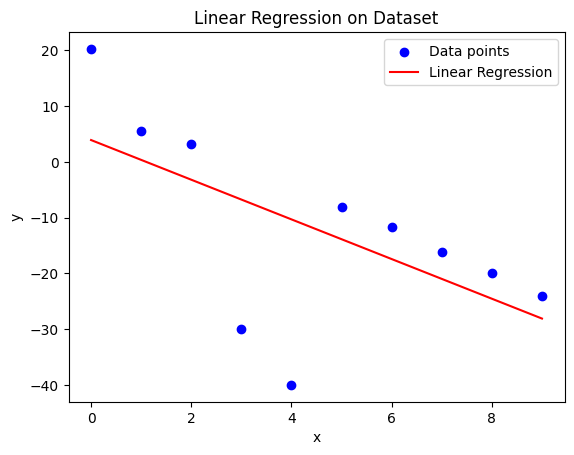

In [10]:
plt.scatter(df['x_i'], df['y_i'], color='blue', label="Data points")

# Predicted line
y_pred = model.predict(X)
plt.plot(df['x_i'], y_pred, color='red', label="Linear Regression")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression on Dataset")
plt.legend()
plt.show()


In [11]:
import numpy as np
import pandas as pd

x = df['x_i'].values
y = df['y_i'].values

# Define the models
def model1(x):
    return -4*x + 12

def model2(x):
    return -3.55*x + 3.91

# Loss function
def robust_loss(y_true, y_pred, beta):
    errors = (y_true - y_pred)**2
    return np.mean(errors / (errors + beta**2))

# Betas
betas = [1, 1e-6, 1e3]

# Calculate losses for both models
results = []
for beta in betas:
    loss_m1 = robust_loss(y, model1(x), beta)
    loss_m2 = robust_loss(y, model2(x), beta)
    results.append([beta, loss_m1, loss_m2])

# Put into DataFrame
df_results = pd.DataFrame(results, columns=["Beta", "Loss_Model1", "Loss_Model2"])
print(df_results)


          Beta  Loss_Model1  Loss_Model2
0     1.000000     0.435416     0.972847
1     0.000001     1.000000     1.000000
2  1000.000000     0.000227     0.000188


What β does

β very small (1e-6):

The denominator ≈ (error² + tiny number) → almost equal to (error²).
So loss ≈ 1 for every sample.
That means all errors, including outliers, dominate equally.
This is not robust, because outliers still strongly influence the model.

β very large (1000):

The denominator ≈ β² (huge number).
So the fraction ≈ error² / β² → almost 0 for all samples.
That means even very large errors (outliers) are shrunk too much — outliers lose all impact, but so do normal points.
This makes the loss function meaningless (it approaches zero regardless of error size).

β = 1 (moderate):

The denominator balances between error² and β².
Small errors contribute meaningfully.
Large errors (outliers) get downweighted (because β² softens their influence).
This is the sweet spot: the model still “listens” to normal points while reducing the impact of extreme outliers.

The suitable β value is β = 1, because:

When β is too small, outliers dominate (loss = 1 for both models).
When β is too large, all points lose their influence (loss ≈ 0).
A moderate β (like 1) strikes a balance: normal points are considered properly, and outliers have reduced influence.

The most suitable model is Model 1: 
𝑦 = −4𝑥 + 12
y=−4x+12, because with the robust estimator at β = 1, it achieves a lower loss (0.4354) compared to Model 2 (0.9728). This shows Model 1 better captures the main trend of the data while mitigating the influence of outliers.

The ordinary regression model (Model 2) was pulled heavily by the large outliers (y=-30 at x=3 and y=-40 at x=4).

The robust estimator downweights these extreme points, giving more importance to the general trend of the other data points.

Under this criterion, Model 1 achieves a significantly lower robust loss, making it the most suitable model for this dataset.

Another robust loss (RANSAC consensus loss)

Define the consensus loss as the fraction of outliers (lower is better):
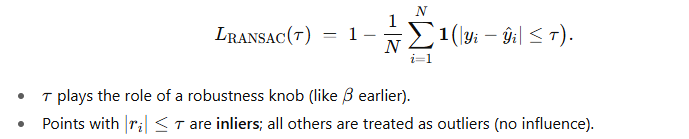

In RANSAC, a model is judged by how many points fall within a small residual threshold 𝜏
τ (the inlier threshold). That naturally down-weights / ignores outliers.              

to compare “fit quality” among inliers, we can use a trimmed MSE over inliers:
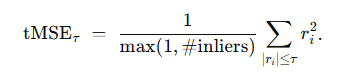

In [ ]:
import numpy as np
import pandas as pd

# loaded DataFrame
x = df['x_i'].values.astype(float)
y = df['y_i'].values.astype(float)

# Given models
def model1(x):
    return -4*x + 12

def model2(x):
    return -3.55*x + 3.91

# RANSAC-style consensus loss: 1 - inlier_ratio
def ransac_consensus_loss(y_true, y_pred, tau):
    residuals = np.abs(y_true - y_pred)
    inliers = residuals <= tau
    inlier_ratio = np.mean(inliers)  # (#inliers) / N
    return 1.0 - inlier_ratio

# trimmed MSE over inliers to break ties / compare quality
def trimmed_mse(y_true, y_pred, tau):
    residuals = y_true - y_pred
    mask = np.abs(residuals) <= tau
    if not np.any(mask):
        return np.inf  # no inliers; treat as worst
    return np.mean(residuals[mask]**2)

# Choose thresholds (like beta list). Tune to noise scale.
taus = [1.0, 2.0, 5.0, 10.0]

# Compute losses
rows = []
for tau in taus:
    y1 = model1(x)
    y2 = model2(x)

    loss1 = ransac_consensus_loss(y, y1, tau)
    loss2 = ransac_consensus_loss(y, y2, tau)

    t_mse1 = trimmed_mse(y, y1, tau)
    t_mse2 = trimmed_mse(y, y2, tau)

    rows.append([tau, loss1, loss2, t_mse1, t_mse2])

df_ransac = pd.DataFrame(rows, columns=[
    "Tau (inlier threshold)",
    "ConsensusLoss_Model1",
    "ConsensusLoss_Model2",
    "tMSE_inliers_Model1",
    "tMSE_inliers_Model2"
])

print(df_ransac)


   Tau (inlier threshold)  ConsensusLoss_Model1  ConsensusLoss_Model2  \
0                     1.0                   0.4                   1.0   
1                     2.0                   0.4                   1.0   
2                     5.0                   0.3                   0.7   
3                    10.0                   0.2                   0.3   

   tMSE_inliers_Model1  tMSE_inliers_Model2  
0             0.139867                  inf  
1             0.139867                  inf  
2             0.935900            20.103767  
3             9.347363            27.511771  


Question 2

In [15]:
import numpy as np
import pandas as pd

# True value
y_true = 1

# Predictions
predictions = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
               0.6, 0.7, 0.8, 0.9, 1.0]

# Initialize lists to store loss values
mse_values = []
bce_values = []

# Calculate MSE and BCE for each prediction
for y_pred in predictions:
    mse = (y_true - y_pred)**2
    # Avoid log(0) error for BCE
    y_pred_clipped = np.clip(y_pred, 1e-15, 1-1e-15)
    bce = - (y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
    
    mse_values.append(round(mse, 6))  # rounded for readability
    bce_values.append(round(bce, 6))

# Create a DataFrame (table)
table = pd.DataFrame({
    'True y': [y_true]*len(predictions),
    'Prediction ŷ': predictions,
    'MSE': mse_values,
    'BCE': bce_values
})

# Print the table
print(table)


    True y  Prediction ŷ       MSE       BCE
0        1         0.005  0.990025  5.298317
1        1         0.010  0.980100  4.605170
2        1         0.050  0.902500  2.995732
3        1         0.100  0.810000  2.302585
4        1         0.200  0.640000  1.609438
5        1         0.300  0.490000  1.203973
6        1         0.400  0.360000  0.916291
7        1         0.500  0.250000  0.693147
8        1         0.600  0.160000  0.510826
9        1         0.700  0.090000  0.356675
10       1         0.800  0.040000  0.223144
11       1         0.900  0.010000  0.105361
12       1         1.000  0.000000  0.000000


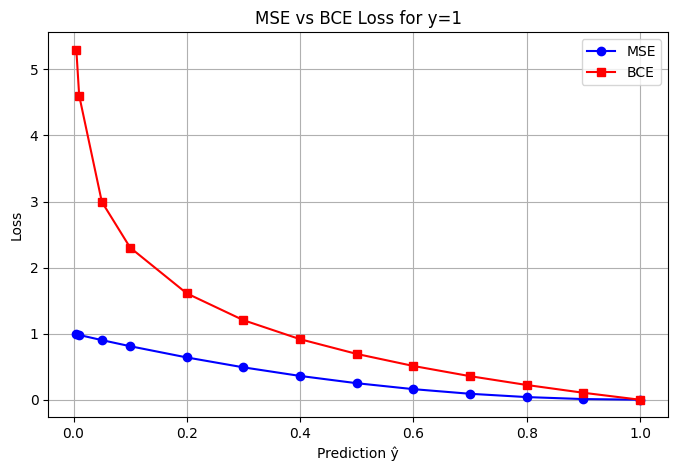

In [16]:
# Plot MSE and BCE
plt.figure(figsize=(8,5))
plt.plot(predictions, mse_values, marker='o', label='MSE', color='blue')
plt.plot(predictions, bce_values, marker='s', label='BCE', color='red')
plt.xlabel('Prediction ŷ')
plt.ylabel('Loss')
plt.title('MSE vs BCE Loss for y=1')
plt.legend()
plt.grid(True)
plt.show()

Application 1: Linear Regression (continuous dependent variable)
Recommended Loss Function: Mean Squared Error (MSE)

Justification:
The dependent variable is continuous, so the model predicts real values.
MSE measures the average squared difference between the true value 𝑦 and the predicted value 𝑦^
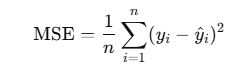
MSE is smooth and differentiable, which allows efficient optimization with gradient-based methods.
Penalizes larger errors more than smaller ones, which is appropriate for regression tasks.
MSE is standard and ideal for continuous output predictions in linear regression.

Application 2: Logistic Regression (binary dependent variable, y∈{0,1})
Recommended Loss Function: Binary Cross-Entropy (BCE)

Justification:
The dependent variable is binary (0 or 1), so the model predicts probabilities y^∈[0,1].
BCE (also called log loss) measures the difference between the true label and the predicted probability:
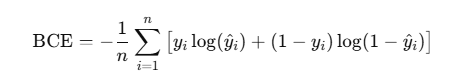
BCE penalizes confident wrong predictions heavily (e.g., predicting 0 when true y = 1).
MSE is not ideal for binary classification because it treats probability errors linearly, which may cause slow convergence and poorly calibrated probabilities.
BCE is the appropriate choice for binary classification and logistic regression.

Question 3